# Self Organizing Maps


Self Organizing Maps are a non-linear clustering method that take inspiration from biological brains, but in a very different way than ANNs.

In this lab. we'll take a look in how to implement a SOM and, especially how to visualize and interpret it.



#### External resources:
* [Clean tensorflow implementation](https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/)
(the skeleton and some utils of this exercise come from here)
* [Advanced tensorflow implementation](https://github.com/cgorman/tensorflow-som), session and GPU management
(the umatrix visualization comes from here).


## Important points for implementation
When dealing with SOMs, there are two 'spaces', or raferences, to keep into account:
1. the *input space*, in which the dataset is defined. This is the high dimensionality space.
2. the *map space*, in which the map represents its output. This is the low (usually 2 for visualizations),
dimensionality space

`Neurons` have both a position in both spaces, and thus a distance. Keep in mind which space and distance are you using 
at each given time


In [162]:
# Loading dependencies by running the code block below.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
sns.set()
sns.set_style("dark")


## SOM class skeleton


In [ ]:

class SOM:
    def __init__(self, m: int, n: int, dim: int, n_iterations: int = 100, radius: float = None, sigma: float = None):
        self._m = m
        self._n = n
        self._dim = dim
        self._n_iterations = n_iterations
        self._radius = radius or max(m, n) / 10.0
        self._sigma = sigma or 0.1

        # np doesn't allow argmin over multiple axis, so we squash the first two dimensions (will make find the BMU easy)
        self.map = np.random.rand(m * n, dim)
        
        self.locations = self._location_matrix()

        # Get the map distance between each neuron (i.e. not the weight distance).
        # distance[i][j] = distance between neuron i and neuron j
        #  [[0.        , 1.        , 1.        , 1.41421356],
        # [1.        , 0.        , 1.41421356, 1.        ],
        # [1.        , 1.41421356, 0.        , 1.        ],
        # [1.41421356, 1.        , 1.        , 0.        ]]
        self.distances = distance_matrix(self.locations, self.locations)

    def train(self, data):
        # TODO
        pass

    def eval(self, data):
        # TODO
        pass

    def get_umatrix(self):
        """
        Generates an M x N u-matrix of the SOM's weights.

        Used to visualize higher-dimensional data. Shows the average distance between a SOM unit and its neighbors.
        When displayed, areas of a darker color separated by lighter colors correspond to clusters of units which
        encode similar information.
        """
        umatrix = np.zeros((self._m * self._n, 1))

        for i in range(self._m * self._n):
            # Get the indices of the units which neighbor i
            neighbor_idxs = self.distances[i] <= 1  # Change this to `< 2` if you want to include diagonal neighbors
            # Get the weights of those units
            neighbor_weights = self.map[neighbor_idxs]
            # Get the average distance between unit i and all of its neighbors
            # Expand dims to broadcast to each of the neighbors
            umatrix[i] = distance_matrix(np.expand_dims(self.map[i], 0), neighbor_weights).mean()

        return umatrix.reshape((self._m, self._n))

    def get_weight_matrix(self):
        """
        Returns the map weights with the proper M x N
        """
        return self.map.reshape((self._m, self._n, self._dim))

    def _get_bmu(self, d):
        # TODO
        pass

    def _location_matrix(self):
        # Get the location of the neurons on the map to figure out their neighbors
        neuron_locs = list()
        for i in range(self._m):
            for j in range(self._n):
                neuron_locs.append(np.array([i, j]))

        return neuron_locs

    def _proximity_constraint(self, bmu):
        # TODO
        pass
    
    def _iteration_constraint(self, t):
        # TODO formula from the slides
        pass


## Color sorting

The first implementation/test on SOM it's usually color sorting. If we make a map with a neuron size of 3 and we use
color values to train it, it's possible to simply show the weight matrix as an image and each 'cluster' will be visible
as a clump of color. Of course this approach does not scale in higher dimensionality (unless we use some tricks)

#### TODO
This week the notebook will be a bit less detailed and will be integrated more during the lab. An edited version will be
added on learnIt later  
1. implement `_get_bmu`,  `_proximity_constraint` and `_iteration_constraint` method, check that the results match with
the example
2. implement `train` method
3. implement the `evaluate` method  


In [282]:
colors_dataset = pd.read_csv('./data/colors.csv')

features = ['R', 'G', 'B']
labels = 'Name'
colors_dataset['Train'] = 1
colors_dataset.loc[15:, 'Train'] = 0


In [284]:
som = SOM(20, 30, len(features), 100)
som.train(colors_dataset[colors_dataset['Train'] == 1][features].values)
evaluated = som.eval(colors_dataset[colors_dataset['Train'] == 0][features].values)


## Cluster analysis and visualization


In [286]:
def visualize_weights(w, evaluation=None, eval_labels=None, train_eval=None, train_labels=None, ax=None):
    if ax is None:
        ax = plt
    
    ax.imshow(w[:, :, :3])
    
    if evaluation is not None:
        for i, m in enumerate(evaluation):
            ax.text(m[1], m[0], eval_labels[i], ha='center', va='center',
                     bbox=dict(facecolor='red', alpha=0.5, lw=0))
            
    if train_eval is not None:
        for i, m in enumerate(train_eval):
            ax.text(m[1], m[0], train_labels[i], ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.5, lw=0))
    
        
def visualize_map(umatrix, evaluation, lbls, ax=None, legend=None):
    if ax is None:
        ax = plt
    
    vis_eval = np.array(evaluation).transpose()
    ax.imshow(umatrix, cmap='gray_r')
    sns.scatterplot(x=vis_eval[1], y=vis_eval[0], hue=lbls, legend=legend, palette='tab10', ax=ax)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    
def som_summary(som, evaluation, labels, classes):
    _, axs = plt.subplots(1, 2, figsize=(15, 30))
    
    visualize_weights(som.get_weight_matrix(), evaluation, classes, ax=axs[0])
    visualize_map(som.get_umatrix(), evaluation, labels, axs[1], legend='full')
    

No handles with labels found to put in legend.


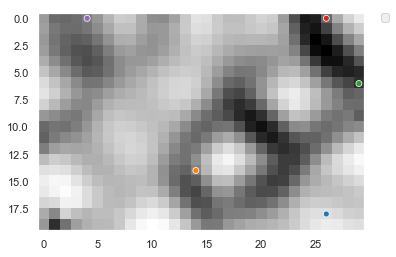

In [287]:
visualize_map(som.get_umatrix(), evaluated, colors_dataset[colors_dataset['Train'] == 0][labels].squeeze().values)


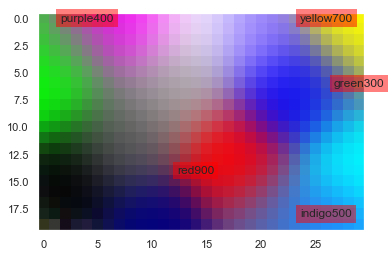

In [288]:
visualize_weights(som.get_weight_matrix(), evaluated, eval_labels=colors_dataset[colors_dataset['Train'] == 0][labels].squeeze().values)


## Application on real dataset


In [289]:
fifa_dataset = pd.read_csv('./data/fifa.csv')
fifa_dataset['Goalkeeper'] = fifa_dataset['Position'] == 'GK'

In [302]:
features = ['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing',
            'BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina',
            'Strength','LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure',
            'Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']
labels = 'Goalkeeper'
som = SOM(20, 30, len(features), 100)

# manually split to maintain a meaningful ratio between GK and non-GK 
# fifa_train = fifa_dataset.loc[:99]
# fifa_eval = fifa_dataset.loc[200:224]
fifa_train = fifa_dataset.sample(100)
fifa_eval = fifa_dataset.sample(25)


# normalization
fifa_train[features] /= 100
fifa_eval[features] /= 100


In [303]:
tmp = fifa_train[features].values
som.train(tmp)
print('train done')

train done


In [304]:
evaluated = som.eval(fifa_eval[features].values)
evaluated


[array([ 7, 16]),
 array([0, 6]),
 array([ 7, 29]),
 array([8, 8]),
 array([ 5, 29]),
 array([19,  0]),
 array([13,  1]),
 array([ 6, 18]),
 array([15,  5]),
 array([17, 18]),
 array([15,  7]),
 array([ 7, 28]),
 array([14,  9]),
 array([14,  1]),
 array([ 6, 11]),
 array([ 0, 26]),
 array([15, 21]),
 array([19,  5]),
 array([ 5, 19]),
 array([12, 23]),
 array([ 7, 11]),
 array([ 6, 27]),
 array([0, 0]),
 array([ 2, 29]),
 array([ 8, 14])]

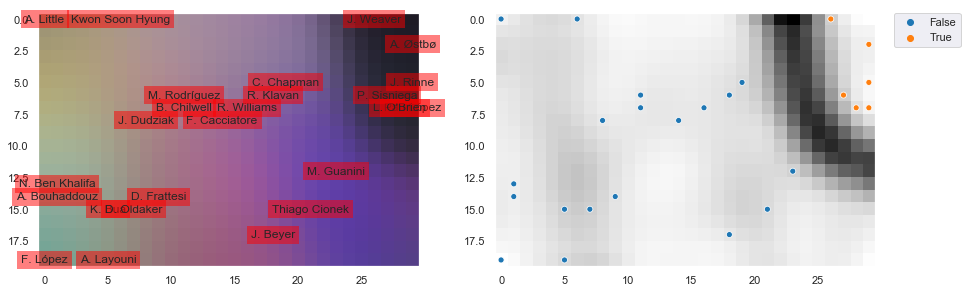

In [305]:
som_summary(som, evaluated, fifa_eval[labels].squeeze().values, fifa_eval['Name'].squeeze().values)


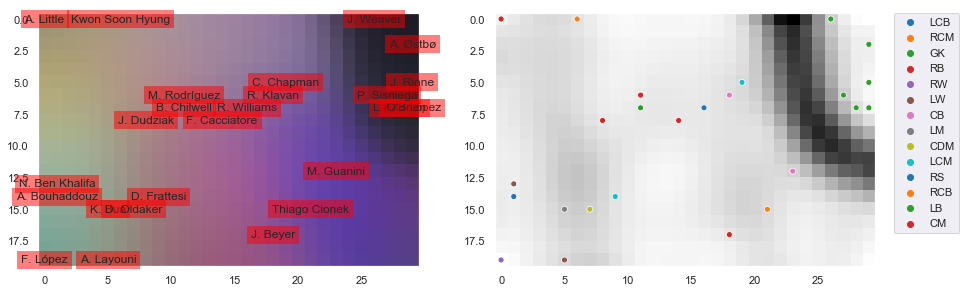

In [306]:
som_summary(som, evaluated, fifa_eval['Position'].squeeze().values, fifa_eval['Name'].squeeze().values)
